<a href="https://colab.research.google.com/github/oraziotorre/TTinsight/blob/main/TTinsight_ModelDevelopment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TTinsight


---


## Model Development


### Inizializzazione

In [13]:
# Gestione dei dati
import pandas as pd
import numpy as np
from collections import Counter
import ast
import math
import joblib

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning e metriche
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    log_loss,
    f1_score,
)

# Deep Learning con Keras e TensorFlow
import tensorflow as tf
from sklearn.svm import SVC
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input,
    LSTM,
    Dense,
    Concatenate,
    Masking,
    Embedding,
    Dropout,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.sequence import pad_sequences

# Scaler fixed for non binary values
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib


In [14]:
dataset = pd.read_csv("cleaned_dataset.csv")

dataset

,players_gender_M,players_gender_W,players_gender_X,is_final,final_set,opponent_final_set,player_points,set_result
0,0,1,0,1,0,0,"[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...",0
1,0,1,0,1,0,0,"[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...",1
2,0,1,0,1,0,0,"[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...",1
3,0,1,0,1,0,0,"[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...",0
4,0,1,0,1,0,0,"[1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 6, 7, ...",1
...,...,...,...,...,...,...,...,...
139203,1,0,0,0,0,0,"[0, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 6, 6, 7, 8, ...",1
139204,1,0,0,0,0,1,"[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...",1
139205,1,0,0,0,1,0,"[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...",0
139206,1,0,0,0,1,1,"[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 6, 6]",0


### Funzioni di supporto

**DECIDERE COSA FARE:
TOGLIERLI DIRETTAMENTE NEL DATAPREPROCESSING
OPPURE TENERLI E USARE UNA TECNICA AGGIUNTIVA**


Le prestazioni del modello calano se manteniamo le situazioni in cui si arriva
ai vantaggi 10-10

 **Non considerariamo i casi di 10-10 e parità a salire**.

 Questo aiuta a ridurre la **complessità e la variabilità del modello**, migliorando la sua capacità di generalizzare su dati più comuni e rilevanti.

 Questi casi rari influiscono l'efficacia del modello, in quanto aumentano il rischio di overfitting e introducono rumore nei dati.

In [15]:
import ast

def generate_score_sequence(player_points):
    # Se player_points è vuoto o non valido, restituiamo una lista vuota (evitando righe nulle)
    if not player_points:
        return []

    # Se player_points è una stringa che sembra una lista, la convertiamo in una lista effettiva
    if isinstance(player_points, str):
        try:
            player_points = ast.literal_eval(player_points)  # Converte la stringa in una lista
        except (ValueError, SyntaxError):
            return []  # Se non è una lista valida, ritorniamo una lista vuota

    # Verifica che player_points sia effettivamente una lista di numeri
    if isinstance(player_points, list):
        try:
            # Converte i valori in interi se sono numeri come stringhe
            player_points = [int(x) for x in player_points]
        except ValueError:
            return []  # Se ci sono errori di conversione, ritorniamo una lista vuota

    # Crea una sequenza delle liste
    sequence = [list(player_points[:i]) for i in range(1, len(player_points) + 1)]
    return sequence

# Generiamo e esplodiamo la colonna
dataset['player_points'] = dataset['player_points'].apply(generate_score_sequence)


# Esplodiamo la colonna 'player_points'
dataset = dataset.explode('player_points', ignore_index=True)

dataset


,players_gender_M,players_gender_W,players_gender_X,is_final,final_set,opponent_final_set,player_points,set_result
0,0,1,0,1,0,0,[0],0
1,0,1,0,1,0,0,"[0, 0]",0
2,0,1,0,1,0,0,"[0, 0, 1]",0
3,0,1,0,1,0,0,"[0, 0, 1, 2]",0
4,0,1,0,1,0,0,"[0, 0, 1, 2, 2]",0
...,...,...,...,...,...,...,...,...
2414867,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7]",1
2414868,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8]",1
2414869,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9]",1
2414870,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 9]",1


In [16]:
import pandas as pd
import ast  # Per convertire una stringa in lista

'''
Abbiamo visto che quando togliamo tutti i casi che vanno ai vantaggi
la probabilità che fornisce il nostro modello tende sempre a essere superiore
alla probabilità teorica che dovrebbe riportare
Considerandoli invece tutti i vantaggi ma solo fino al 10-10 allora....

Considerandoli invece tutti i vantaggi ma solo fino al 10-9 allora....
'''


def remove_rows_with_large_player_points(df):
    # Funzione che verifica la lunghezza della lista
    def check_length(player_points):
        try:
            # Se player_points è una stringa, proviamo a convertirla in una lista
            if isinstance(player_points, str):
                player_points = ast.literal_eval(player_points)
            # Verifica la lunghezza della lista
            return len(player_points) < 20
        except:
            # In caso di errore (es. dati non validi), consideriamo la riga come valida
            return True

    # Filtra le righe in base alla lunghezza della lista
    df_filtered = df[df['player_points'].apply(check_length)]
    return df_filtered

dataset = remove_rows_with_large_player_points(dataset)
dataset

,players_gender_M,players_gender_W,players_gender_X,is_final,final_set,opponent_final_set,player_points,set_result
0,0,1,0,1,0,0,[0],0
1,0,1,0,1,0,0,"[0, 0]",0
2,0,1,0,1,0,0,"[0, 0, 1]",0
3,0,1,0,1,0,0,"[0, 0, 1, 2]",0
4,0,1,0,1,0,0,"[0, 0, 1, 2, 2]",0
...,...,...,...,...,...,...,...,...
2414867,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7]",1
2414868,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8]",1
2414869,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9]",1
2414870,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 9]",1


Per LSTM.
Effettuiamo una trasformazione del player_points in un formato binario per migliorare le prestazioni del modello

L'idea è di rappresentare ogni punto del gioco come un cambiamento rispetto al punto precedente.
**Utilizzando 1 e 0**, il modello può catturare se un giocatore ha guadagnato o meno il punto rispetto al precedente.
Questo permette alla rete neurale di **concentrarsi sul cambiamento tra i punti (vittoria o perdita di un punto)**, piuttosto che sui valori assoluti dei punteggi.
La rete dovrà capire come evolvono i punteggi (vittorie e sconfitte nei punti), non necessariamente il punteggio esatto.

In [17]:
'''
Trasformazione dei set in sequenze di 1 e 0
'''

# Converte i numeri in un altro formato
def transform_player_points(points):
    transformed = []

    for i in range(len(points)):
        points[i] = int(points[i])  # Conversione del punteggio in int per evitare problemi di tipo

        # Per il primo punteggio, aggiungiamo 1 se il punteggio è maggiore di 0, altrimenti 0
        if i == 0:
            transformed.append(1 if points[i] > 0 else 0)
        else:
            # Aggiungiamo 1 se il punteggio è maggiore del precedente, altrimenti 0
            transformed.append(1 if points[i] > points[i - 1] else 0)

    return transformed

dataset['player_points'] = dataset['player_points'].apply(transform_player_points)

# Visualizza il dataframe risultante per verificare le trasformazioni applicate
dataset


<ipython-input-17-c63a21b1882d>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['player_points'] = dataset['player_points'].apply(transform_player_points)


,players_gender_M,players_gender_W,players_gender_X,is_final,final_set,opponent_final_set,player_points,set_result
0,0,1,0,1,0,0,[0],0
1,0,1,0,1,0,0,"[0, 0]",0
2,0,1,0,1,0,0,"[0, 0, 1]",0
3,0,1,0,1,0,0,"[0, 0, 1, 1]",0
4,0,1,0,1,0,0,"[0, 0, 1, 1, 0]",0
...,...,...,...,...,...,...,...,...
2414867,1,0,0,0,1,1,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]",1
2414868,1,0,0,0,1,1,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1]",1
2414869,1,0,0,0,1,1,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]",1
2414870,1,0,0,0,1,1,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0]",1


In [18]:
def aggiungi_rimonte_per_punti(dataset):
    # Inizializziamo le variabili per calcolare le rimonte
    punti_a = 0
    punti_b = 0
    max_rimonta_a = 0
    max_rimonta_b = 0
    rimonta_a = 0
    rimonta_b = 0


    # Liste per memorizzare i risultati delle rimonte
    punteggi_a = []
    punteggi_b = []
    rimonta_piu_lunga_a = []
    rimonta_piu_lunga_b = []
    rimonta_corrente_a = []
    rimonta_corrente_b = []

    # Cicliamo attraverso ogni riga del dataset
    for points in dataset['player_points']:

        max_rimonta_a = 0
        max_rimonta_b = 0
        rimonta_a = 0
        rimonta_b = 0
        punti_a = 0
        punti_b = 0

        # Cicliamo su ogni punto nella lista
        for point in points:
            if point == 1:
                # Rimonta a
                rimonta_a += 1
                rimonta_b = 0  # Reset rimonta b
                max_rimonta_a = max(max_rimonta_a, rimonta_a)
                rimonta_a_corrente = rimonta_a
                rimonta_b_corrente = rimonta_b
                punti_a += 1
            elif point == 0:
                # Rimonta b
                rimonta_b += 1
                rimonta_a = 0  # Reset rimonta a
                max_rimonta_b = max(max_rimonta_b, rimonta_b)
                rimonta_b_corrente = rimonta_b
                rimonta_a_corrente = rimonta_a
                punti_b += 1

        # Aggiungiamo i valori delle rimonte alle liste
        rimonta_piu_lunga_a.append(max_rimonta_a)
        rimonta_piu_lunga_b.append(max_rimonta_b)
        rimonta_corrente_a.append(rimonta_a_corrente)
        rimonta_corrente_b.append(rimonta_b_corrente)
        punteggi_a.append(punti_a)
        punteggi_b.append(punti_b)

    # Aggiungiamo le nuove colonne al dataset
    dataset.loc[:, 'max_rimonta_a'] = rimonta_piu_lunga_a
    dataset.loc[:, 'max_rimonta_b'] = rimonta_piu_lunga_b
    dataset.loc[:, 'rimonta_corrente_a'] = rimonta_corrente_a
    dataset.loc[:, 'rimonta_corrente_b'] = rimonta_corrente_b
    dataset.loc[:, 'punti_a'] = punteggi_a
    dataset.loc[:, 'punti_b'] = punteggi_b


    return dataset

# Applicare la funzione al tuo dataset
dataset = aggiungi_rimonte_per_punti(dataset)
dataset

<ipython-input-18-b1eeeb128f11>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:, 'max_rimonta_a'] = rimonta_piu_lunga_a
<ipython-input-18-b1eeeb128f11>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:, 'max_rimonta_b'] = rimonta_piu_lunga_b
<ipython-input-18-b1eeeb128f11>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

,players_gender_M,players_gender_W,players_gender_X,is_final,final_set,opponent_final_set,player_points,set_result,max_rimonta_a,max_rimonta_b,rimonta_corrente_a,rimonta_corrente_b,punti_a,punti_b
0,0,1,0,1,0,0,[0],0,0,1,0,1,0,1
1,0,1,0,1,0,0,"[0, 0]",0,0,2,0,2,0,2
2,0,1,0,1,0,0,"[0, 0, 1]",0,1,2,1,0,1,2
3,0,1,0,1,0,0,"[0, 0, 1, 1]",0,2,2,2,0,2,2
4,0,1,0,1,0,0,"[0, 0, 1, 1, 0]",0,2,2,0,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2414867,1,0,0,0,1,1,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]",1,6,2,0,2,7,5
2414868,1,0,0,0,1,1,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1]",1,6,2,1,0,8,5
2414869,1,0,0,0,1,1,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]",1,6,2,2,0,9,5
2414870,1,0,0,0,1,1,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0]",1,6,2,0,1,9,6


In [7]:
# Selezioniamo le feature numeriche (quelle che finiscono con '_a' e '_b')
numeric_columns = ['max_rimonta_a', 'max_rimonta_b', 'rimonta_corrente_a', 'rimonta_corrente_b', 'punti_a', 'punti_b']
X_numeric = dataset[numeric_columns].values

# Selezioniamo le feature binarie (ad esempio quelle relative al genere, stato finale, etc.)
binary_columns = ['players_gender_M', 'players_gender_W', 'is_final', 'final_set', 'opponent_final_set']
X_binary = dataset[binary_columns].values

# Target binario
Y = np.array(dataset['set_result'].values)

# Split dei dati in training e test
X_train_numeric, X_test_numeric, X_train_binary, X_test_binary, Y_train, Y_test = train_test_split(
    X_numeric, X_binary, Y, test_size=0.2, random_state=42)

### Logistic Regression L1

In [ ]:
# Normalizzazione dei dati (applica lo scaler)
scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric)  # Allena lo scaler sui dati di training
X_test_numeric_scaled = scaler.transform(X_test_numeric)        # Usa solo il transform per i dati di test

# Concatenare le variabili numeriche scalate con le variabili binarie non scalate
X_train_final = np.hstack([X_train_numeric_scaled, X_train_binary])  # Uniamo i dati numerici e binari
X_test_final = np.hstack([X_test_numeric_scaled, X_test_binary])    # Uniamo i dati numerici e binari

# Logistic Regression con L1
log_reg_l1 = LogisticRegression(penalty='l1', solver='liblinear')
log_reg_l1.fit(X_train_final, Y_train)

# Previsione sui dati di test
y_pred_l1 = log_reg_l1.predict(X_test_final)

# Calcolare l'accuratezza sui dati di test
print("Logistic Regression L1 Accuracy:", accuracy_score(Y_test, y_pred_l1))

Logistic Regression L1 Accuracy: 0.7262540112550154


### Logistic Regression L2

In [ ]:
# Normalizzazione dei dati (applica lo scaler)
scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric)  # Allena lo scaler sui dati di training
X_test_numeric_scaled = scaler.transform(X_test_numeric)        # Usa solo il transform per i dati di test

# Concatenare le variabili numeriche scalate con le variabili binarie non scalate
X_train_final = np.hstack([X_train_numeric_scaled, X_train_binary])  # Uniamo i dati numerici e binari
X_test_final = np.hstack([X_test_numeric_scaled, X_test_binary])    # Uniamo i dati numerici e binari

# Logistic Regression con L1
log_reg_l2 = LogisticRegression(penalty='l2', solver='liblinear')
log_reg_l2.fit(X_train_final, Y_train)

# Previsione sui dati di test
y_pred_l2 = log_reg_l2.predict(X_test_final)

# Calcolare l'accuratezza sui dati di test
print("Logistic Regression L1 Accuracy:", accuracy_score(Y_test, y_pred_l2))

Logistic Regression L2 Accuracy: 0.7262540112550154


In [ ]:
test_sequences = [[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1],
                  [1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]]

# Lista finale per memorizzare le sequenze trasformate
test_sequences_final = []

# Calcolo delle rimonte e punti
for points in test_sequences:
    max_rimonta_a = 0
    max_rimonta_b = 0
    rimonta_a = 0
    rimonta_b = 0
    punti_a = 0
    punti_b = 0

    # Cicliamo su ogni punto nella lista
    for point in points:
        if point == 1:
            # Rimonta a
            rimonta_a += 1
            rimonta_b = 0  # Reset rimonta b
            max_rimonta_a = max(max_rimonta_a, rimonta_a)
            rimonta_a_corrente = rimonta_a
            rimonta_b_corrente = rimonta_b
            punti_a += 1
        elif point == 0:
            # Rimonta b
            rimonta_b += 1
            rimonta_a = 0  # Reset rimonta a
            max_rimonta_b = max(max_rimonta_b, rimonta_b)
            rimonta_b_corrente = rimonta_b
            rimonta_a_corrente = rimonta_a
            punti_b += 1

    # Aggiungiamo la sequenza elaborata a test_sequences_final
    test_sequences_final.append([max_rimonta_a, max_rimonta_b, rimonta_a_corrente, rimonta_b_corrente, punti_a, punti_b])

# Creiamo lo scaler
scaler = StandardScaler()

# Adattiamo lo scaler ai dati di addestramento (X_train) per evitare "data leakage"
scaler.fit(X_train_numeric)

# Applicare lo scaling alla nuova sequenza di test
test_sequences_scaled = scaler.transform(test_sequences_final)

# Previsione con probabilità per la classe 1 (usiamo predict_proba per ottenere probabilità)
probabilità = log_reg_l1.predict_proba(test_sequences_scaled)

# La probabilità per la classe 1 (colonna 1)
print("Probabilità per la classe 1:", probabilità[1][1])

Probabilità per la classe 1: 0.4840478823817682


### XGboost Random Forest

In [ ]:
from xgboost import XGBClassifier

# Crea il modello XGBoost
xgboost = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='logloss')

# Allena il modello
xgboost.fit(X_train_final, Y_train)

# Predizioni
y_pred_xgb = xgboost.predict(X_test_final)

# Valuta la performance
print("XGBoost Accuracy:", accuracy_score(Y_test, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:39:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.7262646936918075


### SVM

In [ ]:
scaler_svm = StandardScaler()

# Applichiamo lo scaling sui dati numerici per entrambi i set di addestramento e test
X_train_numeric_scaled_svm = scaler_svm.fit_transform(X_train_numeric)
X_test_numeric_scaled_svm = scaler_svm.transform(X_test_numeric)

# Concatenare le variabili numeriche scalate con le variabili binarie non scalate
X_train_final_svm = np.hstack([X_train_numeric_scaled_svm, X_train_binary])
X_test_final_svm = np.hstack([X_test_numeric_scaled_svm, X_test_binary])

# 1. Linear Kernel SVM
svm_linear = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
svm_linear.fit(X_train_final_svm, Y_train)
joblib.dump(svm_linear, 'svm_linear_model.pkl')

# Predizioni e probabilità
y_pred_linear = svm_linear.predict(X_test_final_svm)
y_pred_proba_linear = svm_linear.predict_proba(X_test_final_svm)[:, 1]  # Probability for class 1

print("Linear Kernel Accuracy:", accuracy_score(Y_test, y_pred_linear))
print("Linear Kernel Probabilities:", y_pred_proba_linear)

# 2. RBF Kernel SVM
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True)
svm_rbf.fit(X_train_final_svm, Y_train)
joblib.dump(svm_rbf, 'svm_rbf_model.pkl')

# Predizioni e probabilità
y_pred_rbf = svm_rbf.predict(X_test_final_svm)
y_pred_proba_rbf = svm_rbf.predict_proba(X_test_final_svm)[:, 1]  # Probability for class 1

print("RBF Kernel Accuracy:", accuracy_score(Y_test, y_pred_rbf))
print("RBF Kernel Probabilities:", y_pred_proba_rbf)

# 3. Polynomial Kernel SVM
svm_poly = SVC(kernel='poly', C=1.0, degree=3, random_state=42, probability=True)
svm_poly.fit(X_train_final_svm, Y_train)
joblib.dump(svm_poly, 'svm_poly_model.pkl')

# Predizioni e probabilità
y_pred_poly = svm_poly.predict(X_test_final_svm)
y_pred_proba_poly = svm_poly.predict_proba(X_test_final_svm)[:, 1]  # Probability for class 1

print("Polynomial Kernel Accuracy:", accuracy_score(Y_test, y_pred_poly))
print("Polynomial Kernel Probabilities:", y_pred_proba_poly)

# 4. Sigmoid Kernel SVM
svm_sigmoid = SVC(kernel='sigmoid', C=1.0, random_state=42, probability=True)
svm_sigmoid.fit(X_train_final_svm, Y_train)
joblib.dump(svm_sigmoid, 'svm_sigmoid_model.pkl')

# Predizioni e probabilità
y_pred_sigmoid = svm_sigmoid.predict(X_test_final_svm)
y_pred_proba_sigmoid = svm_sigmoid.predict_proba(X_test_final_svm)[:, 1]  # Probability for class 1

print("Sigmoid Kernel Accuracy:", accuracy_score(Y_test, y_pred_sigmoid))
print("Sigmoid Kernel Probabilities:", y_pred_proba_sigmoid)

In [ ]:
# Test sequences (input example)
test_sequences = [[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1],
                  [1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]]

# Lista finale per memorizzare le sequenze trasformate
test_sequences_final = []

# Calcolo delle rimonte e punti
for points in test_sequences:
    max_rimonta_a = 0
    max_rimonta_b = 0
    rimonta_a = 0
    rimonta_b = 0
    punti_a = 0
    punti_b = 0

    for point in points:
        if point == 1:
            rimonta_a += 1
            rimonta_b = 0
            max_rimonta_a = max(max_rimonta_a, rimonta_a)
            punti_a += 1
        elif point == 0:
            rimonta_b += 1
            rimonta_a = 0
            max_rimonta_b = max(max_rimonta_b, rimonta_b)
            punti_b += 1

    test_sequences_final.append([max_rimonta_a, max_rimonta_b, rimonta_a, rimonta_b, punti_a, punti_b])

# Preprocessing delle sequenze di test
# Applicare lo scaler sui dati numerici, per mantenere la consistenza con l'addestramento
test_sequences_numeric = np.array([seq[:6] for seq in test_sequences_final])  # Prendiamo solo le feature numeriche
test_sequences_binary = np.array([seq[6:] for seq in test_sequences_final])  # Prendiamo solo le feature binarie

# Scaling delle feature numeriche
test_sequences_numeric_scaled = scaler_svm.transform(test_sequences_numeric)

# Concatenare le variabili numeriche scalate con le variabili binarie non scalate
test_sequences_preprocessed = np.hstack([test_sequences_numeric_scaled, test_sequences_binary])

# Previsioni con i modelli
print("\nProbabilità per la classe 1 (per ogni sequenza):")

# 1. SVM Linear Kernel
probs_linear = svm_linear.predict_proba(test_sequences_preprocessed)
print("SVM Linear Kernel:", probs_linear[:, 1])

# 2. SVM RBF Kernel
probs_rbf = svm_rbf.predict_proba(test_sequences_preprocessed)
print("SVM RBF Kernel:", probs_rbf[:, 1])

# 3. SVM Polynomial Kernel
probs_poly = svm_poly.predict_proba(test_sequences_preprocessed)
print("SVM Polynomial Kernel:", probs_poly[:, 1])

# 4. SVM Sigmoid Kernel (aggiunto per completezza)
probs_sigmoid = svm_sigmoid.predict_proba(test_sequences_preprocessed)
print("SVM Sigmoid Kernel:", probs_sigmoid[:, 1])


#### Cross validation

In [ ]:
X = np.array((dataset[['players_gender_M'	,'players_gender_W',	'players_gender_X','is_final', 'final_set', 'opponent_final_set','num_values', 'num_duplicates', 'entropy', 'sum_values']].values))

#X = np.array((dataset[['num_values', 'num_duplicates', 'entropy', 'sum_values']].values))

Y = np.array(dataset['set_result'].values)  # Target binari

# K-Fold Cross Validation
logreg_model_kf = LogisticRegression(max_iter=1000, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies_kf = []
classification_reports_kf = []
roc_auc_kf = []
log_losses_kf = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Addestramento
    logreg_model_kf.fit(X_train, Y_train)

    # Predizioni
    Y_pred = logreg_model_kf.predict(X_test)
    Y_pred_prob = logreg_model_kf.predict_proba(X_test)

    # Valutazione
    accuracy = accuracy_score(Y_test, Y_pred)
    accuracies_kf.append(accuracy)
    classification_reports_kf.append(classification_report(Y_test, Y_pred))

    # ROC Curve e AUC
    fpr_kf, tpr_kf, _ = roc_curve(Y_test, Y_pred_prob[:, 1])
    roc_auc = auc(fpr_kf, tpr_kf)
    roc_auc_kf.append(roc_auc)

    # Log Loss
    log_loss_value = log_loss(Y_test, Y_pred_prob)
    log_losses_kf.append(log_loss_value)

# Media delle performance
mean_accuracy_kf = np.mean(accuracies_kf)
mean_roc_auc_kf = np.mean(roc_auc_kf)
mean_log_loss_kf = np.mean(log_losses_kf)

print(f"Accuratezza media K-Fold: {mean_accuracy_kf:.2f}")
print(f"AUC media K-Fold: {mean_roc_auc_kf:.2f}")
print(f"Log Loss medio K-Fold: {mean_log_loss_kf:.2f}")

Accuratezza media K-Fold: 0.79
AUC media K-Fold: 0.88
Log Loss medio K-Fold: 0.44


### Random Forest

In [ ]:
X = np.array((dataset[['players_gender_M'	,'players_gender_W',	'players_gender_X','is_final', 'final_set', 'opponent_final_set']].values))

Y = np.array(dataset['set_result'].values)  # Target binari

# Crea il modello di Random Forest
rf = RandomForestClassifier(random_state=42)

# Variabili per raccogliere i risultati
feature_importances = []

# Divisione train-test (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

rf.fit(X_train, Y_train)

# Nomi delle feature
feature_names = ['players_gender_M', 'players_gender_W', 'players_gender_X', 'is_final',
                 'final_set', 'opponent_final_set']


# Estrai le feature importance per ogni albero
tree_importances = np.array([tree.feature_importances_ for tree in rf.estimators_])

# Calcola la media e la deviazione standard per ogni feature
mean_importances = tree_importances.mean(axis=0)
std_importances = tree_importances.std(axis=0)

In [ ]:
X = np.array((dataset[['max_rimonta_a', 'max_rimonta_b', 'rimonta_corrente_a', 'rimonta_corrente_b', 'punti_a',	'punti_b']].values))

Y = np.array(dataset['set_result'].values)  # Target binari

# Crea il modello di Random Forest
rf = RandomForestClassifier(random_state=42)

# Variabili per raccogliere i risultati
feature_importances = []

# Divisione train-test (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

rf.fit(X_train, Y_train)

# Nomi delle feature
feature_names = ['max_rimonta_a', 'max_rimonta_b', 'rimonta_corrente_a', 'rimonta_corrente_b', 'punti_a',	'punti_b']


# Estrai le feature importance per ogni albero
tree_importances = np.array([tree.feature_importances_ for tree in rf.estimators_])

# Calcola la media e la deviazione standard per ogni feature
mean_importances = tree_importances.mean(axis=0)
std_importances = tree_importances.std(axis=0)

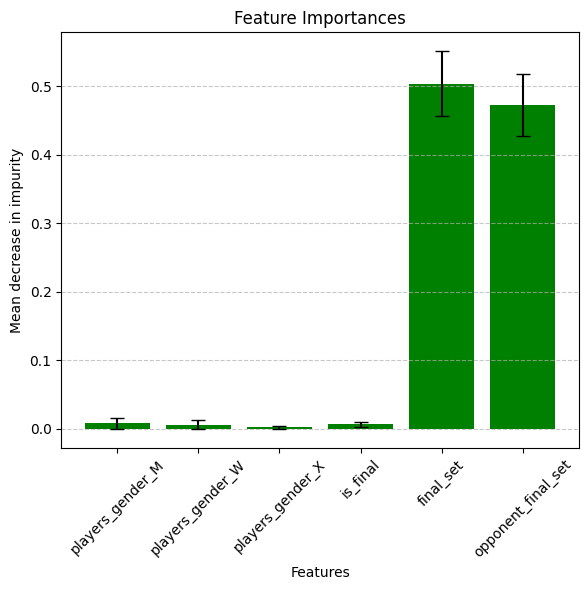

In [ ]:
# Grafico con barre e barre d'errore
plt.figure(figsize=(6, 6))
plt.bar(feature_names, mean_importances, yerr=std_importances, color="green", alpha=1, capsize=5)
plt.title("Feature Importances")
plt.ylabel("Mean decrease in impurity")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
'''
vedo l'importanza di ciascun punto per ogni tipologia di set
11-0 , 11-1,.....,11-9

DECIDI SE CANCELLARLO E CONSIDERARE SOLO LE FEATURE USATE NEL LOGISTIC REGRESSION
'''


# Paddiamo tutte le sequenze di player_points in anticipo
player_points_padded = pad_sequences(dataset['player_points'], padding='post', truncating='post', value=-1)

# Utilizziamo solo player_points come feature, senza altre colonne
X = player_points_padded

# Target binario Y
Y = np.array(dataset['set_result'].values)

# Creiamo il modello di Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Itera su ogni possibile lunghezza di player_points da 10 a 19
for length in range(10, 20):
    # Filtra il dataset per includere solo i dati con player_points di lunghezza 'length'

    indices = np.where([len(points) == length for points in dataset['player_points']])[0]

    # Seleziona X e Y per gli indici selezionati
    X_subset = X[indices]
    Y_subset = Y[indices]

    # Suddividi il dataset in train-test (80% train, 20% test)
    X_train, X_test, Y_train, Y_test = train_test_split(X_subset, Y_subset, test_size=0.2, random_state=42, stratify=Y_subset)

    # Allena il modello sui dati di addestramento
    rf_model.fit(X_train, Y_train)

    # Estrai l'importanza delle feature per questo modello
    importances = rf_model.feature_importances_

    importances_trimmed = importances[:length]
    print(len(importances_trimmed))
    # Nomi delle feature (solo player_point_1, player_point_2, ..., player_point_19)
    feature_names = [f'player_point_{i}' for i in range(1, length+1)]


    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances_trimmed, y=feature_names, palette="viridis")
    plt.title("Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

### LSTM

 **LSTM** (Long Short-Term Memory), un tipo di rete neurale ricorrente è il modello che abbiamo deciso di utilizzare per effettuare previsioni sulle vittorie del set o meno.
 - LSTM può imparare come i punteggi cambiano in **base alle azioni precedenti**, ovvero, consentono di prevedere il risultato finale della partita basato **sull'andamento dei punteggi** (rimonta o stallo) durante il set.
 - Le variabili "is_final", "final_set", "opponent_final_set", permettono di integrare queste variabili temporali in modo che il modello non solo predica un punteggio finale, ma può anche tener conto di eventi come **"l'ultimo set"** o **"l'avversario in difficoltà"**.

 E' possibile migliorare questo modello per facilitarlo successivamente

In [ ]:
# Verifichiamo che 'player_points' sia una lista di interi
player_points = np.array(dataset['player_points'].values)
set_result = np.array(dataset['set_result'].values)  # Target binari

X_train_raw, X_test_raw, Y_train, Y_test = train_test_split(player_points, set_result, test_size=0.2, random_state=42, stratify=set_result)


# Effettuiamo il padding per le sequenze di training e test
X_train = pad_sequences(X_train_raw, maxlen=20, padding='post', truncating='post', value=-1)
X_test = pad_sequences(X_test_raw, maxlen=20, padding='post', truncating='post', value=-1)

# Reshape del target
Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)


# Creazione del modello
'''
Abbiamo convertito le sequenze di interi in sequenze binarie.
Questo perchè i valori non ci interessano ci interessano solo
la sequenza temporale dei punteggi

INFINE AGGIUNGERE ANCHE LE ALTRE FEATURE

Esperimenti con lunghezza di sequenza massima 19, 128 batch, 3 epoche e con tutte le combinazioni
L'attuale modello sembra dare predizioni veritiere
si noti il caso 1,1,1,1,0,0,0,0 prob. di vincere di 0.5284746
invece il caso 0,0,0,0,1,1,1,1 prob. di vincere di 0.4808944

Analizzare meglio le prestazioni dei diversi modelli

Ho analizzato le prestazioni con learning rate differenti
e non ho notato grandi differenze. Con n learning rate di
0.0001 rispetto a 0.001
si noti il caso 1,1,1,1,0,0,0,0 prob. di vincere di 0.50075436
invece il caso 0,0,0,0,1,1,1,1 prob. di vincere di 0.48774242
sembra penalizza maggiormente quando si subisce un recupero
'''

model = Sequential([
    Embedding(input_dim=3, output_dim=32),
    LSTM(64, return_sequences=True),
    LSTM(32, return_sequences=False),
    Dropout(0.3),  # Probabilità di disattivare un nodo
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilazione del modello
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Allenamento del modello
history = model.fit(X_train, Y_train, epochs=5, batch_size=128)

Epoch 1/5
14627/14627 ━━━━━━━━━━━━━━━━━━━━ 808s 55ms/step - accuracy: 0.7237 - loss: 0.5345
Epoch 2/5
14627/14627 ━━━━━━━━━━━━━━━━━━━━ 722s 49ms/step - accuracy: 0.7272 - loss: 0.5246
Epoch 3/5
14627/14627 ━━━━━━━━━━━━━━━━━━━━ 834s 56ms/step - accuracy: 0.7281 - loss: 0.5227
Epoch 4/5
14627/14627 ━━━━━━━━━━━━━━━━━━━━ 812s 52ms/step - accuracy: 0.7278 - loss: 0.5222
Epoch 5/5
14627/14627 ━━━━━━━━━━━━━━━━━━━━ 765s 50ms/step - accuracy: 0.7277 - loss: 0.5223


In [ ]:
model.save('modelAdv20.keras')

In [ ]:
# Verifichiamo che 'player_points' sia una lista di interi
player_points = np.array(dataset['player_points'].values)
set_result = np.array(dataset['set_result'].values)  # Target binari

X_train_raw, X_test_raw, Y_train, Y_test = train_test_split(player_points, set_result, test_size=0.2, random_state=42, stratify=set_result)


# Effettuiamo il padding per le sequenze di training e test
X_train = pad_sequences(X_train_raw, maxlen=19, padding='post', truncating='post', value=-1)
X_test = pad_sequences(X_test_raw, maxlen=19, padding='post', truncating='post', value=-1)

# Reshape del target
Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)


# Creazione del modello
'''
Abbiamo convertito le sequenze di interi in sequenze binarie.
Questo perchè i valori non ci interessano ci interessano solo
la sequenza temporale dei punteggi

INFINE AGGIUNGERE ANCHE LE ALTRE FEATURE

Esperimenti con lunghezza di sequenza massima 19, 128 batch, 3 epoche e con tutte le combinazioni
L'attuale modello sembra dare predizioni veritiere
si noti il caso 1,1,1,1,0,0,0,0 prob. di vincere di 0.5284746
invece il caso 0,0,0,0,1,1,1,1 prob. di vincere di 0.4808944

Analizzare meglio le prestazioni dei diversi modelli

Ho analizzato le prestazioni con learning rate differenti
e non ho notato grandi differenze. Con n learning rate di
0.0001 rispetto a 0.001
si noti il caso 1,1,1,1,0,0,0,0 prob. di vincere di 0.50075436
invece il caso 0,0,0,0,1,1,1,1 prob. di vincere di 0.48774242
sembra penalizza maggiormente quando si subisce un recupero
'''

model = Sequential([
    Embedding(input_dim=3, output_dim=32),
    LSTM(64, return_sequences=True),
    LSTM(32, return_sequences=False),
    Dropout(0.3),  # Probabilità di disattivare un nodo
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilazione del modello
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Allenamento del modello
history = model.fit(X_train, Y_train, epochs=5, batch_size=128)

Epoch 1/5
 9486/14627 ━━━━━━━━━━━━━━━━━━━━ 4:04 48ms/step - accuracy: 0.7216 - loss: 0.5366

KeyboardInterrupt: 

In [ ]:
model.save('modelAdv19.keras')

In [ ]:
#Funzione che calcola matematicamente la probabilità di vittoria del set

from math import comb

def prob(p, x, y):
    # Somma della prima parte
    sum_part1 = 0
    for i in range(0, 10 - y):
        sum_part1 += p**(11 - x) * math.comb(10 + i - x, i) * (1 - p)**i

    # Seconda parte della formula
    part2 = p**(10 - x) * math.comb(20 - x - y, 10 - x) * (1 - p)**(10 - y)
    part2 *= (p**2) / (1 - 2 * p * (1 - p))

    # Somma totale
    total = sum_part1 + part2
    return total

# Esempio di uso
p = 0.5  # Probabilità di vincere un punto
x = 8    # Punti già vinti dal giocatore
y = 8    # Punti già vinti dall'avversario

result = prob(p, x, y)
print("Probabilità:", result)

Probabilità: 0.5


In [ ]:
def prob(p, x, y):

    total = p**(10 - x) * math.comb(20 - x - y, 10 - x) * (1 - p)**(10 - y)

    return total

# Esempio di uso
p = 0.5  # Probabilità di vincere un punto
x = 6    # Punti già vinti dal giocatore
y = 6    # Punti già vinti dall'avversario

result = prob(p, x, y)
print("Probabilità:", result)

Probabilità: 0.2734375


In [ ]:
from keras.models import load_model
# Previsione
model = load_model('modelAdv20.keras')


test_sequences = [[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1],
                  [1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]]
padded_test_sequences = pad_sequences(
    test_sequences,
    maxlen = 20,  #Ricordati di cambiare 19 o 20 a seconda del modello che utilizzi
    padding ='post',
    truncating ='post',
    value = -1
)

probabilità = model.predict(padded_test_sequences)

# La probabilità per la classe 1 (output di sigmoid)
print(probabilità[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
0.4702404


In [ ]:
# Testing del modello
Y_pred = model.predict(X_test)
Y_pred_binary = (Y_pred > 0.5).astype(int)  # Converte le probabilità in valori binari

# Calcolo delle metriche di performance
print("Accuracy:", accuracy_score(Y_test, Y_pred_binary))
print("Classification Report:\n", classification_report(Y_test, Y_pred_binary))

  182/14627 ━━━━━━━━━━━━━━━━━━━━ 2:11 9ms/step

KeyboardInterrupt: 

In [ ]:
'''
Test LSTM con tutte le feature
'''

player_points = np.array(dataset['player_points'].values)
set_result = np.array(dataset['set_result'].values)
global_features = np.array(dataset[['players_gender_M', 'players_gender_W', 'players_gender_X', 'is_final', 'final_set', 'opponent_final_set']])

# Padding delle sequenze
max_sequence_length = 19  # Impostato come precedentemente
player_points_padded = pad_sequences(player_points, maxlen=max_sequence_length, padding='post', truncating='post', value=-1)

# Train/Test Split (80/20)
X_train_seq, X_test_seq, Y_train, Y_test, X_train_global, X_test_global = train_test_split(
    player_points_padded, set_result, global_features, test_size=0.2, random_state=42, stratify=set_result
)


# Input per sequenze
sequence_input = Input(shape=(max_sequence_length,), name='sequence_input')

# Embedding con 3 possibili valori di input (es. 0, 1, -1) e vettori di dimensione 32.
x = Embedding(input_dim=3, output_dim=32)(sequence_input)

# Primo strato LSTM con 64 unità, che restituisce l'intera sequenza.
x = LSTM(64, return_sequences=True)(x)

# Secondo strato LSTM con 32 unità, che restituisce solo l'ultimo stato.
x = LSTM(32, return_sequences=False)(x)

# Input per feature globali
global_input = Input(shape=(6,), name='global_input')
global_dense = Dense(16, activation='relu')(global_input)

# Combina i due input
combined = concatenate([x, global_dense])
x = Dropout(0.3)(combined) # Aggiungiamo dropout per ridurre l'overfitting
x = Dense(32, activation='relu')(x) # Strato denso con 32 unità per la combinazione.
output = Dense(1, activation='sigmoid')(x)

# Costruisci il modello
lstm_model = Model(inputs=[sequence_input, global_input], outputs=output)

# Compila il modello
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Allenamento del modello LSTM
history_lstm = lstm_model.fit([X_train_seq, X_train_global], Y_train, epochs=5, batch_size=128)

# Valutazione del modello LSTM
loss_lstm, accuracy_lstm = lstm_model.evaluate([X_test_seq, X_test_global], Y_test, verbose=0)
Y_pred_lstm = lstm_model.predict([X_test_seq, X_test_global])

# Stampa dei risultati
print(f"LSTM - Test Loss: {loss_lstm:.4f}")
print(f"LSTM - Test Accuracy: {accuracy_lstm:.4f}")


In [ ]:
'''
MIGLIORARE I PARAMETRI DELL' LSTM, come qui


# Assicurati che 'player_points' sia una lista di interi
player_points = np.array(dataset['player_points'].values)
set_result = np.array(dataset['set_result'].values)  # Target binari

X_train, X_val, Y_train, Y_val = train_test_split(player_points, set_result, test_size=0.2, random_state=42)
X_train = pad_sequences(X_train, maxlen=19, padding='post', truncating='post', value=-1)
X_val = pad_sequences(X_val, maxlen=19, padding='post', truncating='post', value=-1)

# Reshape del target
Y_train = Y_train.reshape(-1, 1)
Y_val = Y_val.reshape(-1, 1)

model = Sequential([
    Embedding(input_dim=2, output_dim=64),  # Embedding layer (2 valori, 64 neuroni)
    LSTM(128, return_sequences=False),  # LSTM con 128 neuroni
    Dropout(0.5),  # Aggiungi Dropout per evitare overfitting
    Dense(64, activation='relu'),  # Aggiungi un layer Dense intermedio
    Dense(1, activation='sigmoid')  # Output layer per la classificazione binaria
])

# Compilazione del modello
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_val, Y_val), callbacks=[early_stopping])
'''

### Performance Analysis

In [ ]:
# ANALISI DELLA CORRELAZIONE LINEARE DELLE FEATURE
dataset.drop('player_points', axis=1, inplace=True)

corr = dataset.corr()
plt.figure(figsize=(10, 8))  # Aumenta le dimensioni del grafico
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 10}, cbar=True)

# Ruotare le etichette delle colonne per evitare sovrapposizioni
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Mostrare il grafico
plt.tight_layout()  # Regola il layout per evitare sovrapposizioni
plt.show()

#Notiamo che i valori calcoli hanno una relazione lineare

In [ ]:
#ANALISI DELLA PROGRESSIONE DI APPRENDIMENTO del LOGISTIC REGRESSION


X_train_full, X_test, y_train_full, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Lista di dimensioni del training set
training_sizes = np.linspace(10, 400, 10, dtype=int)

# Per salvare gli F1-score
f1_scores = []

# Modello
model = LogisticRegression(max_iter=1000, random_state=42)

# Loop per addestrare il modello su set di training di dimensioni crescenti
for size in training_sizes:
    # Campioni di training ridotti
    X_train_subset = X_train_full[:size]
    y_train_subset = y_train_full[:size]

    # Addestramento del modello
    model.fit(X_train_subset, y_train_subset)

    # Predizione sul set di test
    y_pred = model.predict(X_test)

    # Calcola l'F1-score
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)


# Grafico del cambiamento dell'F1-score
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, f1_scores, marker='o', linestyle='-', color='b', label='F1-score')

# Aggiungi i valori veri sull'asse X
plt.xticks(training_sizes, labels=[str(x) for x in training_sizes], rotation=45)

plt.xlabel('Numero di campioni di training')
plt.ylabel('F1-score (weighted)')
plt.title('Cambiamento dell\'F1-score rispetto ai campioni di training')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# ANALISI DELLE PRESTAZIONI IN BASE ALLA LUNGHEZZA DELLA SEQUENZA - LSTM

# Calcola le lunghezze originali delle sequenze
performance_by_length = {}

# Troviamo gli indici delle sequenze che hanno una lunghezza pari a quella corrente.
sequence_lengths = [len(seq) for seq in X_test_raw]

# Creiamo gruppi basati sulle lunghezze
for length in range(1, 21):  # Lunghezze da 1 a 20
    indices = [idx for idx, seq_length in enumerate(sequence_lengths) if seq_length == length]

    if indices:  # Evita gruppi vuoti
        X_subset = X_test[indices]
        Y_subset = Y_test[indices]
        Y_pred_subset = model.predict(X_subset)

        # Convertiamo le probabilità in valori binari (0 o 1) utilizzando una soglia di 0.5.
        Y_pred_binary_subset = (Y_pred_subset > 0.5).astype(int)

        # Calcoliamo l'accuratezza confrontando i target veri (Y_subset) con le predizioni binarie.
        accuracy = accuracy_score(Y_subset, Y_pred_binary_subset)

        # Salviamo l'accuratezza nel dizionario associandola alla lunghezza corrente.
        performance_by_length[f"{length}"] = accuracy


'''
oppure per il modello con tutte le feature

# Analisi delle prestazioni per lunghezza delle sequenze
performance_by_length = {}
sequence_lengths = [len(seq) for seq in X_test_seq]

# Itera per lunghezze di sequenza da 1 a 20
for length in range(1, 21):  # Lunghezze da 1 a 20
    indices = [idx for idx, seq_length in enumerate(sequence_lengths) if seq_length == length]

    if indices:  # Procedi solo se ci sono sequenze con quella lunghezza
        X_subset = np.array([X_test_seq[idx] for idx in indices])
        Y_subset = np.array([Y_test[idx] for idx in indices])
        X_global_subset = np.array([X_test_global[idx] for idx in indices])

        # Assicurati che le sequenze abbiano la lunghezza corretta (es. padding/truncating)
        X_subset_padded = pad_sequences(X_subset, maxlen=19, padding='post', truncating='post', value=-1)

        # Predici i risultati
        Y_pred_subset = lstm_model.predict([X_subset_padded, X_global_subset])
        Y_pred_binary_subset = (Y_pred_subset > 0.5).astype(int)

        # Calcola l'accuratezza
        accuracy = accuracy_score(Y_subset, Y_pred_binary_subset)
        performance_by_length[f"{length}"] = accuracy
'''

plt.figure(figsize=(8, 6))
# Aggiusta per visualizzare le lunghezze come numeri e l'accuratezza associata
lengths = list(range(1, 21))  # Lunghezze da 1 a 19

# Estraiamo le accuratezze corrispondenti alle lunghezze e se la lunghezza non è presente assegniamo 0
accuracies = [performance_by_length.get(str(length), 0) for length in lengths]

plt.bar(lengths, accuracies, color='skyblue')
plt.xlabel('Lunghezza delle sequenze')
plt.ylabel('Accuratezza')
plt.title('Prestazioni del modello in base alla lunghezza delle sequenze')
plt.xticks(lengths)  # Mostra tutte le lunghezze sull'asse x
plt.show()

In [ ]:
# Calcolo della curva ROC LSTM
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)

# Grafico ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'LSTM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Falso Positivo Rate')
plt.ylabel('Vero Positivo Rate')
plt.title('Curva ROC per LSTM')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Grafico diminuzione della loss durante le poche LSTM
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Curva di apprendimento per LSTM')
plt.legend()
plt.show()

# Grafico miglioramento dell'accuratezza durante le epoche LSTM
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuratezza durante il training per LSTM')
plt.legend()
plt.show()

In [ ]:
# Calcolo della matrice di confusione
cm = confusion_matrix(Y_test, Y_pred_binary)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Non Vinto', 'Vinto'], yticklabels=['Non Vinto', 'Vinto'])
plt.title('Matrice di Confusione per LSTM')
plt.xlabel('Predizioni')
plt.ylabel('Verità Effettive')
plt.show()

In [ ]:
#LOGISTIC REGRESSION VS CROSSVALIDATED LOGISTIC REGRESSION


# Visualizzazione delle performance di Accuratezza
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.bar(['K-Fold', 'Test-Split'], [mean_accuracy_kf, accuracy_ts], color=['blue', 'green'])
plt.title('Confronto Accuratezza')
plt.ylabel('Accuratezza')

# Visualizzazione delle performance di AUC
plt.subplot(1, 3, 2)
plt.bar(['K-Fold', 'Test-Split'], [mean_roc_auc_kf, roc_auc_ts], color=['blue', 'green'])
plt.title('Confronto AUC')
plt.ylabel('AUC')

# Visualizzazione delle performance di Log Loss
plt.subplot(1, 3, 3)
plt.bar(['K-Fold', 'Test-Split'], [mean_log_loss_kf, log_loss_ts], color=['blue', 'green'])
plt.title('Confronto Log Loss')
plt.ylabel('Log Loss')

plt.tight_layout()
plt.show()

# ROC Curve per il confronto visivo
fpr_kf, tpr_kf, _ = roc_curve(Y_test, logreg_model_kf.predict_proba(X_test)[:, 1])
fpr_ts, tpr_ts, _ = roc_curve(Y_test, logreg_model_ts.predict_proba(X_test)[:, 1])

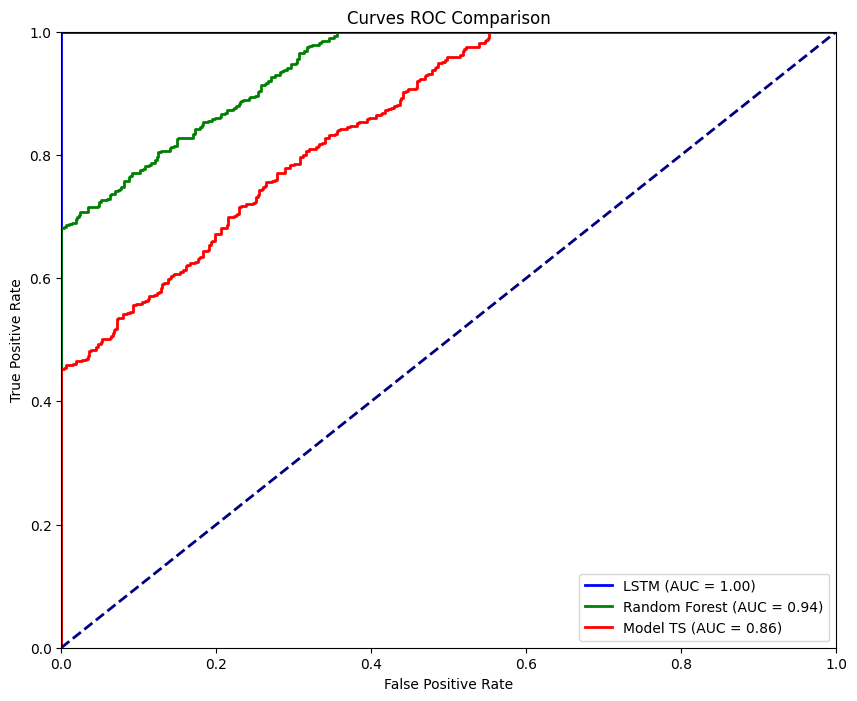

In [ ]:
# CONFRONTO DI ROC CURVE DI MODELLI DIFFERENTI

# Numero di campioni
n_samples = 1000

# Genera etichette vere (0 o 1) casuali
y_true = np.random.randint(0, 2, size=n_samples)


# MODIFICARE QUI, DOBBIAMO METTERE LE PRESTAZIONI VERE
# Genera probabilità predette per i tre modelli con una maggiore separazione tra le classi
# Per i modelli, facciamo in modo che le probabilità per la classe positiva siano abbastanza alte
y_pred_lstm = np.random.rand(n_samples) * 0.5 + (y_true == 1) * 0.5  # maggiore probabilità per classi positive
y_pred_rf = np.random.rand(n_samples) * 0.6 + (y_true == 1) * 0.4  # un po' di separazione maggiore
y_pred_ts = np.random.rand(n_samples) * 0.7 + (y_true == 1) * 0.3  # separazione simile

# Calcola le curve ROC per ogni modello
fpr_lstm, tpr_lstm, _ = roc_curve(y_true, y_pred_lstm)
fpr_rf, tpr_rf, _ = roc_curve(y_true, y_pred_rf)
fpr_ts, tpr_ts, _ = roc_curve(y_true, y_pred_ts)

# Calcola l'AUC per ogni modello
roc_auc_lstm = roc_auc_score(y_true, y_pred_lstm)
roc_auc_rf = roc_auc_score(y_true, y_pred_rf)
roc_auc_ts = roc_auc_score(y_true, y_pred_ts)

# Creazione del grafico
plt.figure(figsize=(10, 8))

# Aggiungi tutte le curve ROC al grafico
plt.plot(fpr_lstm, tpr_lstm, color='blue', lw=2, label=f'LSTM (AUC = {roc_auc_lstm:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_ts, tpr_ts, color='red', lw=2, label=f'Model TS (AUC = {roc_auc_ts:.2f})')

# Linea diagonale (linea di casualità)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Etichette e titolo
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curves ROC Comparison')
plt.legend(loc='lower right')

# Mostra il grafico
plt.show()

In [ ]:
# STATISTICHE PER RANDOM FOREST

# Calcolo della curva ROC

Y_pred = rf_model.predict(X_test)

fpr_rf, tpr_rf, _ = roc_curve(Y_test, Y_pred)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Grafico ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Falso Positivo Rate')
plt.ylabel('Vero Positivo Rate')
plt.title('Curva ROC per RF')
plt.legend(loc='lower right')
plt.show()

# Convertiamo le predizioni in etichette binarie
Y_pred_binary = (Y_pred > 0.5).astype(int)

# Calcolo della matrice di confusione
cm = confusion_matrix(Y_test, Y_pred_binary)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Non Vinto', 'Vinto'], yticklabels=['Non Vinto', 'Vinto'])
plt.title('Matrice di Confusione per RF')
plt.xlabel('Predizioni')
plt.ylabel('Verità Effettive')
plt.show()


In [ ]:
# ?

plt.figure(figsize=(8, 6))
plt.plot(fpr_kf, tpr_kf, color='blue', label=f'K-Fold (AUC = {mean_roc_auc_kf:.2f})')
plt.plot(fpr_ts, tpr_ts, color='green', label=f'Test-Split (AUC = {roc_auc_ts:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve: K-Fold vs Test-Split')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()